In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../data/kmeans_clustered_data.csv', sep=';', header=0, low_memory=False, na_values =["", " "])

In [25]:
df = df.dropna().copy()
df = df.drop(columns=["income"])

In [30]:
from sklearn import tree
from sklearn.model_selection import train_test_split

y = df["income_kmeans_cluster"].copy()
X = df.drop(columns=["income_kmeans_cluster","job", "livelihood"])
#X = df[["household_size", "educational_qualification","primary_residence",]]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

clf = tree.DecisionTreeClassifier()

clf.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit (Accuracy): {accuracy:.2f}")

# Classification Report: Precision, Recall, F1-Score
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))


Genauigkeit (Accuracy): 0.75
Klassifikationsbericht:
              precision    recall  f1-score   support

        high       0.65      0.68      0.67       528
     highest       0.71      0.68      0.70       139
lower middle       0.78      0.84      0.81      1884
      lowest       0.76      0.68      0.72       498
      middle       0.76      0.70      0.73      1398

    accuracy                           0.75      4447
   macro avg       0.73      0.72      0.72      4447
weighted avg       0.75      0.75      0.75      4447



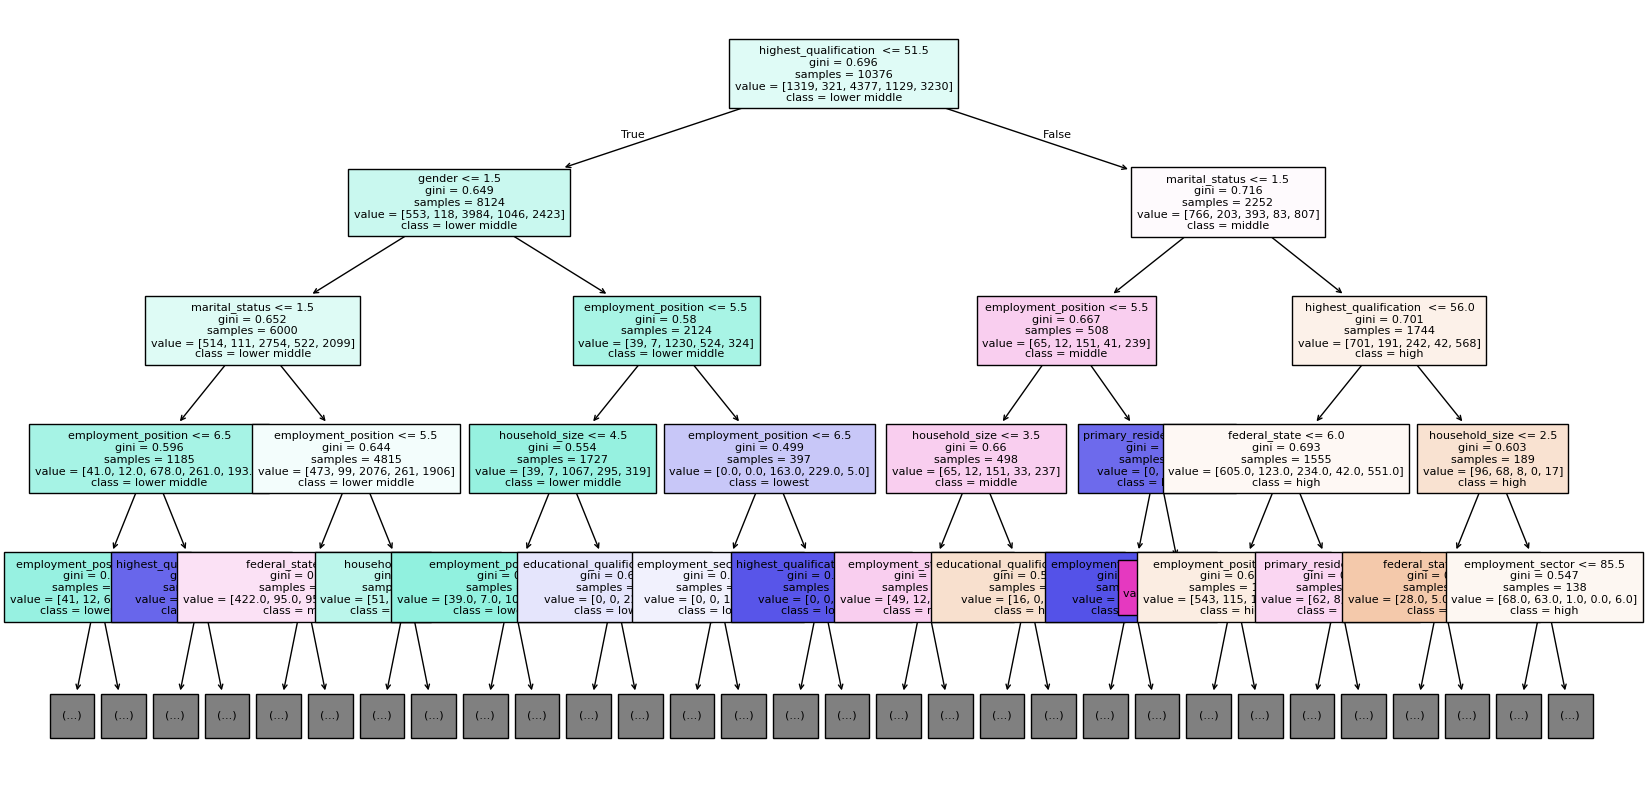

In [32]:
fig_size = plt.figure(figsize=(20,10))
tree.plot_tree(clf,
               feature_names=X.columns,
               class_names=clf.classes_,
               filled=True, 
               fontsize = 8, 
               max_depth=4)
plt.show()